In [1]:
# Sources:
# - CA Secretary of State – Official Voter Guide, Prop 1 hub (title/summary, what your vote means, links to text of law)
#   https://vigarchive.sos.ca.gov/2024/primary/propositions/1/
# - Official Title & Summary (Attorney General) + LAO fiscal estimate
#   https://vigarchive.sos.ca.gov/2024/primary/propositions/1/title-summary.htm
# - Legislative Analyst’s Office overview (plain-language explainer)
#   https://lao.ca.gov/BallotAnalysis/Proposition?number=1&year=2024
# - Ballotpedia summary page for context
#   https://ballotpedia.org/California_Proposition_1%2C_Behavioral_Health_Services_Program_and_Bond_Measure_%28March_2024%29

ballot = """STATE OF CALIFORNIA — PROPOSITION 1 (March 5, 2024)
Behavioral Health Services Program and Bond Measure

OVERVIEW
The Legislature placed this measure on the ballot to update California’s behavioral health system and finance new facilities and housing. It would authorize about $6.38 billion in state general obligation bonds to help build or expand: (1) mental health and substance use treatment facilities and (2) housing and supportive services for people who are homeless or at risk of homelessness and living with behavioral health challenges. The measure also revises the Mental Health Services Act to broaden eligible uses (including substance use disorder services), adjust funding allocations, and add oversight/audit provisions. (AB 531 & SB 326, 2023.)

WHAT YOUR VOTE MEANS (paraphrased)
YES — Counties would shift some behavioral health spending toward housing and personalized supports, and the state could borrow up to $6.4B to add treatment capacity and housing for people with mental health or substance use conditions.
NO — Counties would keep current program emphasis and the state would not issue the new bonds for treatment facilities or housing.

FISCAL EFFECTS (high level)
• Ongoing state bond repayment costs of roughly a few hundred million dollars per year over several decades, depending on issuance and interest.
• Shifts roughly a portion of existing statewide behavioral health tax revenue from counties to state-directed priorities, with programmatic trade-offs.

KEY ELEMENTS
• Bond Authority: Approximately $6.38 billion in state general obligation bonds for facility construction, modernization, and housing tied to behavioral health needs (including dedicated funds for homeless veterans).
• Program Reforms: Updates the Mental Health Services Act to allow funding for substance use disorder treatment in addition to mental health treatment; recalibrates spending categories (e.g., full-service partnerships, early intervention and other services, and housing-related supports); requires regular reporting and audits.
• Populations Served: People with serious mental illness or substance use disorders, including individuals experiencing homelessness or at risk of homelessness; includes veteran-specific housing/support components.

BALLOT LABEL (paraphrased from Official Title & Summary)
Authorizes multi-billion-dollar bonds for mental health and substance use treatment facilities; provides housing/supportive services for individuals experiencing homelessness with behavioral health needs; revises statewide mental health funding rules and oversight; legislative statute.

LEGISLATIVE HISTORY / PLACEMENT
Referred to voters by the California Legislature through AB 531 (Ch. 789, 2023) and SB 326 (Ch. 790, 2023) for the March 5, 2024, statewide election.
"""

In [2]:
"""
Ballot Measure Summarization Workflow

This workflow takes a ballot measure text and:
1. Summarizes it in plain language (300 words)
2. Identifies key stakeholders using structured JSON output
3. Creates a moderated network of stakeholder agents to provide interactive perspectives
"""

import json
import random
from typing import Dict, List, Any, Tuple
from litellm import completion
from plurals.agent import Agent
from plurals.deliberation import Graph, Moderator
from dotenv import load_dotenv

load_dotenv("../src/.env")

def summarize_ballot_measure(ballot_text: str, model: str = "gpt-4o-mini") -> str:
    """
    Step 1: Summarize the ballot measure in plain language

    Args:
        ballot_text: The full text of the ballot measure
        model: LLM model to use

    Returns:
        Plain language summary in ~300 words
    """

    prompt = f"""
    Please summarize the following ballot measure in plain, accessible language that any voter could understand.
    Focus on:
    - What the measure would actually do
    - Who would be affected
    - Key arguments for and against

    Limit your response to approximately 300 words.

    BALLOT MEASURE TEXT:
    {ballot_text}
    """

    response = completion(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    print(response.choices[0].message.content)
    return response.choices[0].message.content

summary_text = summarize_ballot_measure(ballot)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/plurals/helpers.py:238: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


**California Proposition 1 Summary**

**What it Does:**  
Proposition 1 aims to improve California’s behavioral health system by allowing the state to borrow up to $6.38 billion through bonds. This money will be used to build or expand facilities for mental health and substance use treatment, as well as provide housing and support services for people experiencing homelessness or at risk of being homeless and having behavioral health challenges. The measure also updates the Mental Health Services Act to include substance use treatment funding and introduces more oversight and reporting.

**Who is Affected:**  
This measure primarily impacts individuals with serious mental illness or substance use disorders, especially those who are homeless or at risk of homelessness. It also has provisions specifically for veterans needing housing and support.

**Key Arguments For:**  
- **Increased Resources:** Supporters argue that the funding will create much-needed facilities and housing, reducing 

In [ ]:
# --- Example: identify stakeholders and create agents ------------------------
import json
from typing import Dict, List
from dotenv import load_dotenv
from litellm import completion
from plurals.agent import Agent

load_dotenv()

def identify_stakeholders(ballot_text: str, model: str = "gpt-4o-mini") -> Dict[str, List[str]]:
    """
    Identify the top stakeholders for/against the measure using structured JSON.
    Returns exactly 3 supporters and 3 opponents.
    """
    prompt = f"""
    Analyze the ballot measure below and return ONLY valid JSON with exactly:
    {{
      "primary_supporters": ["<specific group>", "<specific group>", "<specific group>"],
      "primary_opponents":  ["<specific group>", "<specific group>", "<specific group>"]
    }}

    Rules:
    - Exactly 3 per side. No explanations or extra keys.
    - Use realistic stakeholder groups relevant to the policy context.

    BALLOT MEASURE TEXT:
    {ballot_text}
    """

    resp = completion(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        response_format={"type": "json_object"},
        temperature=0.2,
    )

    data = json.loads(resp.choices[0].message.content)
    supporters = data.get("primary_supporters", [])[:3]
    opponents = data.get("primary_opponents", [])[:3]

    # pad if model under-returns
    while len(supporters) < 3:
        supporters.append(f"Supporter Placeholder {len(supporters)+1}")
    while len(opponents) < 3:
        opponents.append(f"Opponent Placeholder {len(opponents)+1}")

    return {"primary_supporters": supporters, "primary_opponents": opponents}

# Use your function to create agents
def create_stakeholder_agents(
    stakeholders: Dict[str, List[str]],
    model: str = "gpt-4o-mini",
    temperature: float = 0.7,
) -> List[Agent]:
    agents: List[Agent] = []
    for category, groups in stakeholders.items():
        for group in groups:
            persona = (
                f"You are a representative of {group}. "
                f"Think and respond from their perspective, considering their interests, concerns, and priorities."
            )
            agent = Agent(
                persona=persona,
                model=model,
                kwargs={"temperature": temperature},
            )
            try:
                agent.name = f"{group} ({category.replace('_', ' ').title()})"
            except Exception:
                pass
            agents.append(agent)
    return agents

MODEL = "gpt-4o-mini"
stakeholders = identify_stakeholders(ballot, model=MODEL)
agents = create_stakeholder_agents(stakeholders, model=MODEL)

print("Identified stakeholders:", json.dumps(stakeholders, indent=2))
print("\nCreated agents:")
for i, a in enumerate(agents):
    print(f"{i+1}: {getattr(a, 'name', 'Unnamed Agent')}")
    print(f"   Persona: {a.persona}\n")

Identified stakeholders: {
  "primary_supporters": [
    "California Hospital Association",
    "National Alliance on Mental Illness California",
    "Housing California"
  ],
  "primary_opponents": [
    "California Taxpayers Association",
    "Howard Jarvis Taxpayers Association",
    "California Republican Party"
  ]
}

Created agents:
0: California Hospital Association (Primary Supporters)
   Persona: You are a representative of California Hospital Association. Think and respond from their perspective, considering their interests, concerns, and priorities.

1: National Alliance on Mental Illness California (Primary Supporters)
   Persona: You are a representative of National Alliance on Mental Illness California. Think and respond from their perspective, considering their interests, concerns, and priorities.

2: Housing California (Primary Supporters)
   Persona: You are a representative of Housing California. Think and respond from their perspective, considering their interests, c

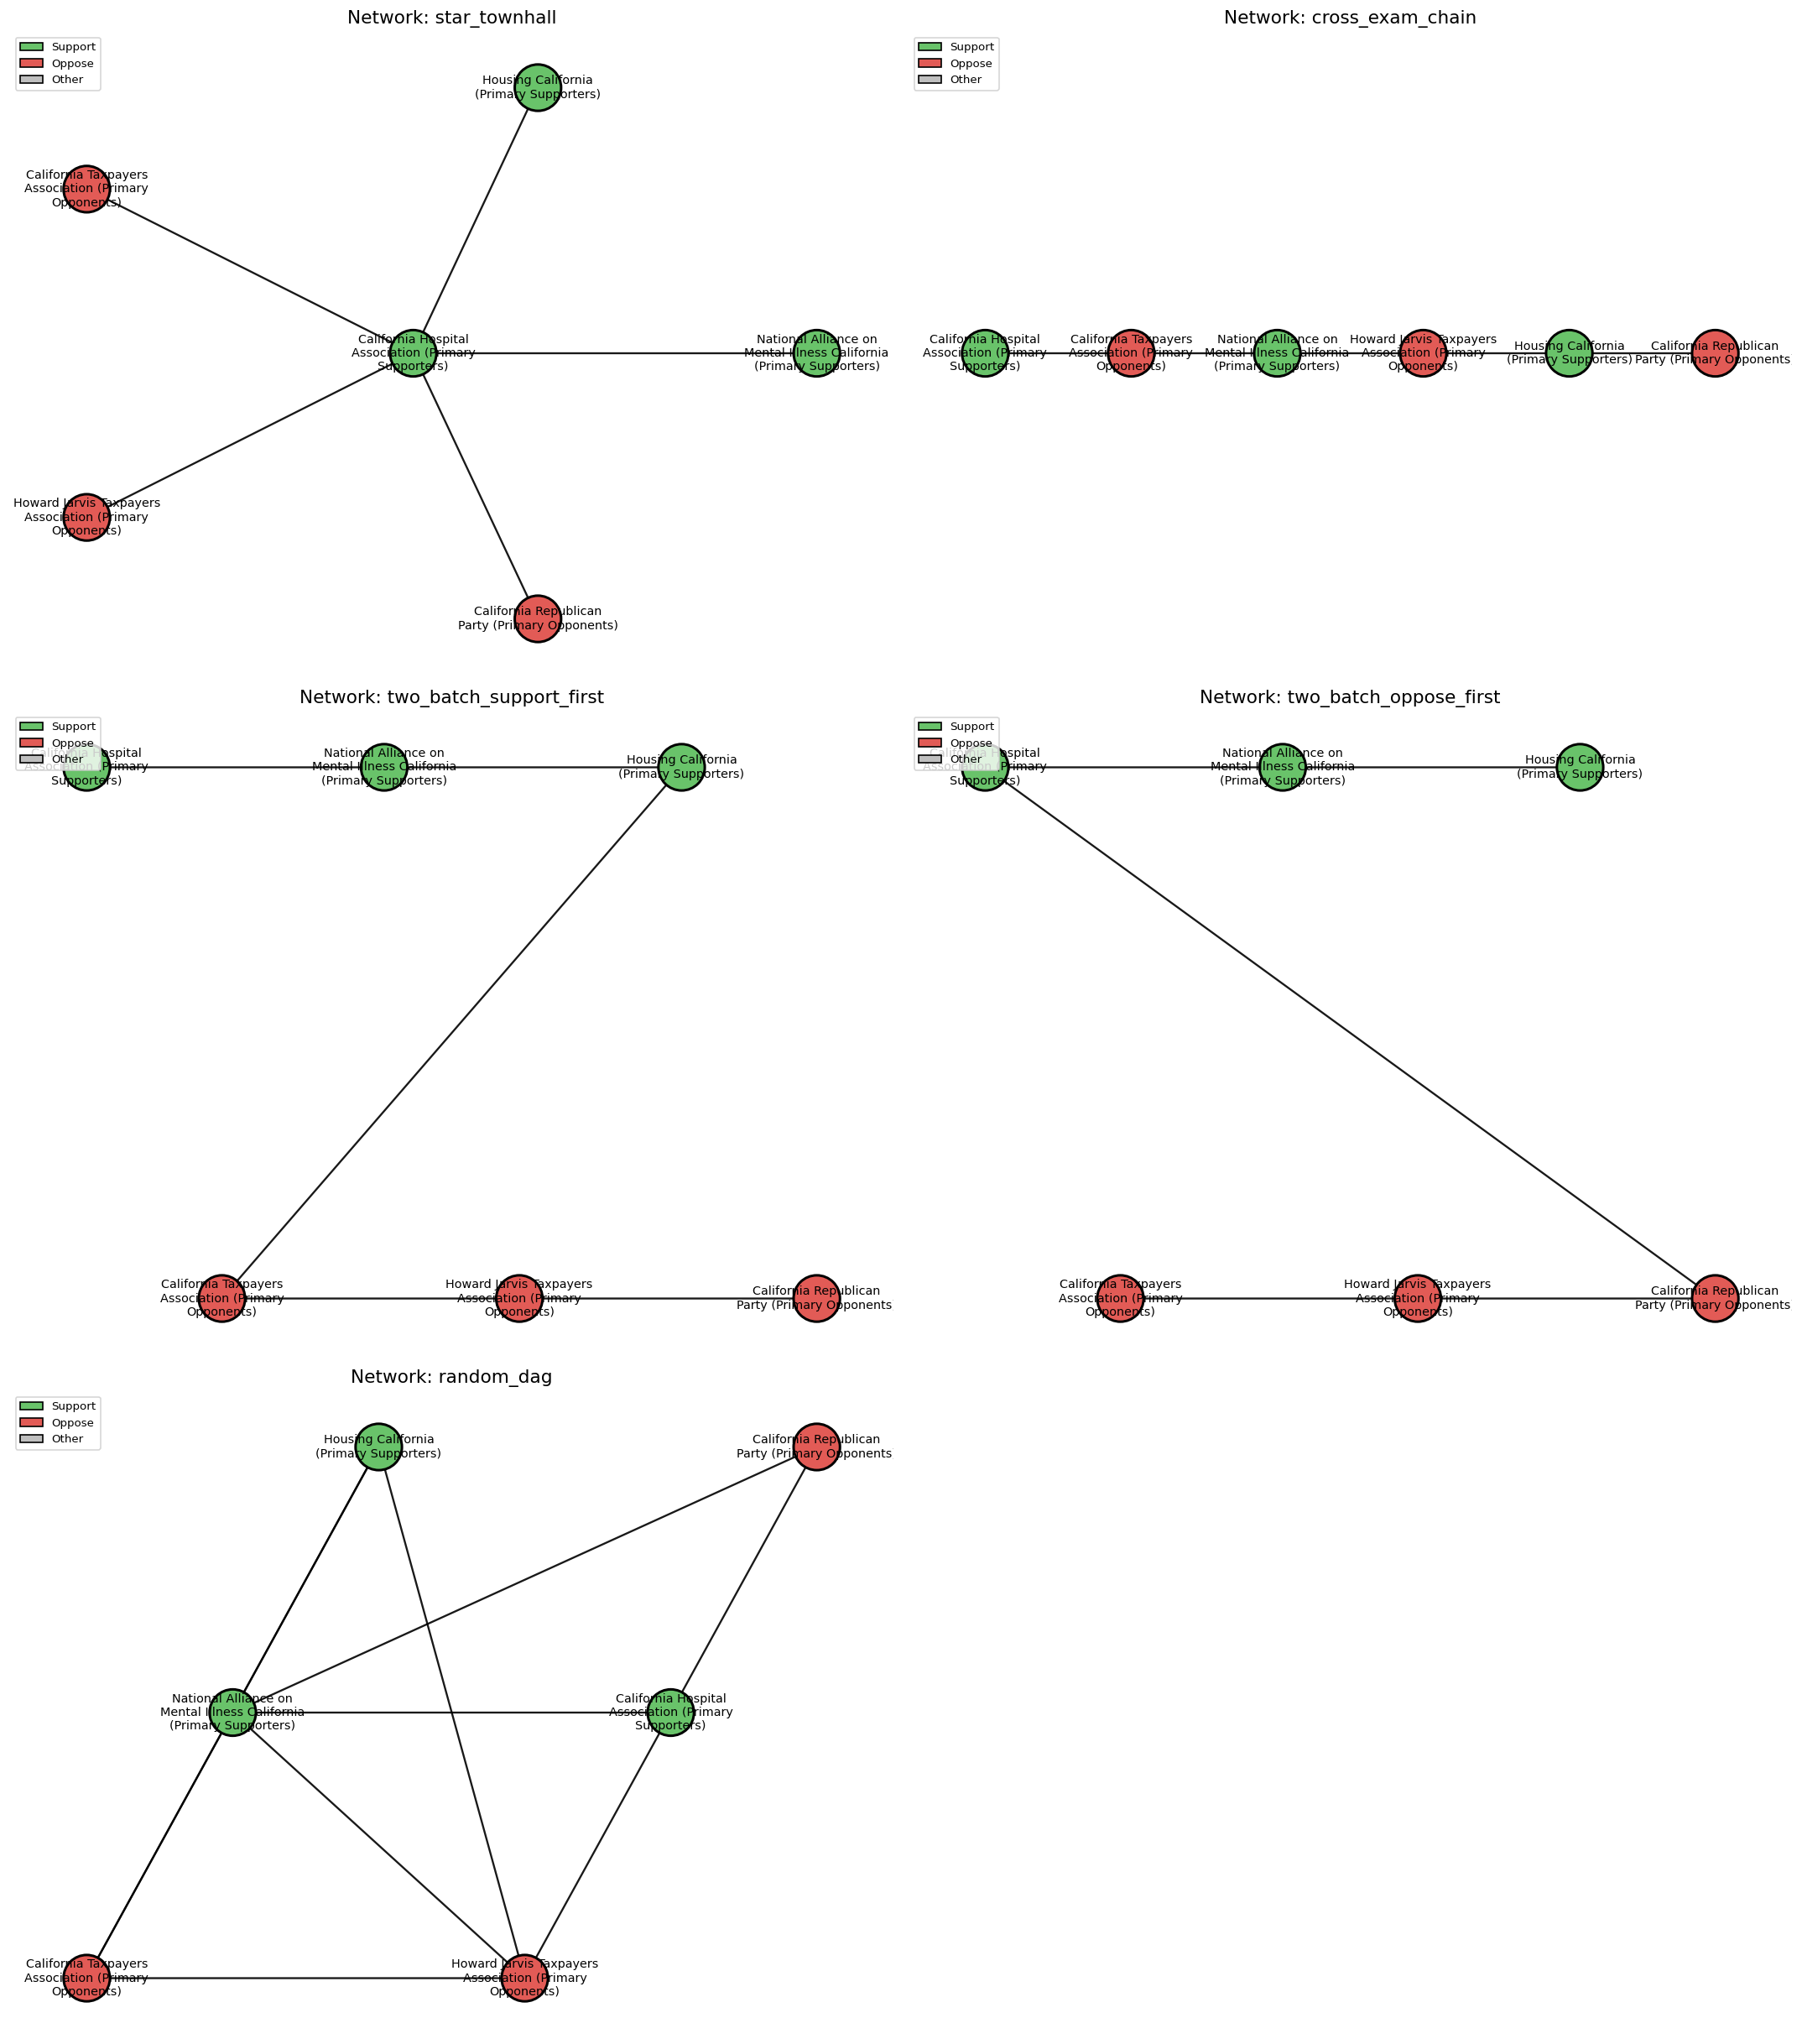

In [11]:
# === Five Networks (no neutral) + Robust Visualization =======================
from typing import List, Tuple, Dict, Any
import math
import random
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from textwrap import wrap
from plurals.agent import Agent

Edge = Tuple[int, int]

# ---------------------------------------------------------------------------
# Stance detection helpers
#   Assumes you created agents via:
#     agent.name = f"{group} ({category.replace('_',' ').title()})"
#   where category ∈ {"primary_supporters","primary_opponents"}.
#   If names differ, we also check persona text as a fallback.
# ---------------------------------------------------------------------------
def _infer_groups(agents: List[Agent]) -> Dict[str, List[int]]:
    sup, opp, other = [], [], []
    for i, a in enumerate(agents):
        nm = (getattr(a, "name", "") or "").lower()
        ps = (getattr(a, "persona", "") or "").lower()
        label = f"{nm} {ps}"
        if ("primary supporters" in label) or ("supporter" in label) or (" support " in f" {label} "):
            sup.append(i)
        elif ("primary opponents" in label) or ("opponent" in label) or (" oppose " in f" {label} "):
            opp.append(i)
        else:
            other.append(i)
    return {"support": sup, "oppose": opp, "other": other}

# ---------------------------------------------------------------------------
# Network builders (all DAGs)
# ---------------------------------------------------------------------------

# 1) Star townhall: choose a hub (prefer first supporter), all others -> hub
def build_star_townhall(agents: List[Agent]) -> Tuple[List[Edge], Dict[str, Any]]:
    idx = _infer_groups(agents)
    hub = idx["support"][0] if idx["support"] else 0
    edges = [(i, hub) for i in range(len(agents)) if i != hub]
    meta = {"name": "star_townhall", "hub": hub}
    return edges, meta

# 2) Cross-exam chain: alternate S/O into a linear chain (acyclic)
def build_cross_exam_chain(agents: List[Agent]) -> Tuple[List[Edge], Dict[str, Any]]:
    idx = _infer_groups(agents)
    S, O = idx["support"], idx["oppose"]
    thread: List[int] = []
    L = min(len(S), len(O))
    for k in range(L):
        thread.extend([S[k], O[k]])
    if len(S) > L:
        thread.extend(S[L:])
    if len(O) > L:
        thread.extend(O[L:])
    edges: List[Edge] = [(thread[i], thread[i+1]) for i in range(len(thread)-1)] if len(thread) > 1 else []
    meta = {"name": "cross_exam_chain", "order": thread}
    return edges, meta

# 3) Two-batch support-first: chain all S, connect S→O, chain all O
def build_two_batch_support_first(agents: List[Agent]) -> Tuple[List[Edge], Dict[str, Any]]:
    idx = _infer_groups(agents)
    S, O = idx["support"], idx["oppose"]
    edges: List[Edge] = []
    for i in range(len(S)-1):
        edges.append((S[i], S[i+1]))
    if S and O:
        edges.append((S[-1], O[0]))
    for i in range(len(O)-1):
        edges.append((O[i], O[i+1]))
    meta = {"name": "two_batch_support_first", "support": S, "oppose": O}
    return edges, meta

# 4) Two-batch oppose-first: chain all O, connect O→S, chain all S
def build_two_batch_oppose_first(agents: List[Agent]) -> Tuple[List[Edge], Dict[str, Any]]:
    idx = _infer_groups(agents)
    S, O = idx["support"], idx["oppose"]
    edges: List[Edge] = []
    for i in range(len(O)-1):
        edges.append((O[i], O[i+1]))
    if O and S:
        edges.append((O[-1], S[0]))
    for i in range(len(S)-1):
        edges.append((S[i], S[i+1]))
    meta = {"name": "two_batch_oppose_first", "support": S, "oppose": O}
    return edges, meta

# 5) Random DAG (reproducible, acyclic, connected):
#    sample a random topological order, add forward edges by prob p,
#    then add a forward backbone chain to ensure connectivity.
def build_random_dag(agents: List[Agent], p: float = 0.35, seed: int = 42) -> Tuple[List[Edge], Dict[str, Any]]:
    rnd = random.Random(seed)
    n = len(agents)
    order = list(range(n))
    rnd.shuffle(order)

    edges: List[Edge] = []
    for i in range(n):
        for j in range(i+1, n):
            u, v = order[i], order[j]
            if rnd.random() < p:
                edges.append((u, v))
    for i in range(n-1):
        u, v = order[i], order[i+1]
        if (u, v) not in edges:
            edges.append((u, v))

    edges = list(dict.fromkeys(edges))
    meta = {"name": "random_dag", "p": p, "seed": seed, "topo_order": order}
    return edges, meta

# Registry
def build_five_network_registry(agents: List[Agent]) -> Dict[str, Dict[str, Any]]:
    nets: Dict[str, Dict[str, Any]] = {}
    e, m = build_star_townhall(agents);          nets["star_townhall"]          = {"agents": agents, "edges": e, "meta": m}
    e, m = build_cross_exam_chain(agents);       nets["cross_exam_chain"]       = {"agents": agents, "edges": e, "meta": m}
    e, m = build_two_batch_support_first(agents);nets["two_batch_support_first"]= {"agents": agents, "edges": e, "meta": m}
    e, m = build_two_batch_oppose_first(agents); nets["two_batch_oppose_first"] = {"agents": agents, "edges": e, "meta": m}
    e, m = build_random_dag(agents, p=0.35, seed=42)
    nets["random_dag"] = {"agents": agents, "edges": e, "meta": m}
    return nets

# ---------------------------------------------------------------------------
# Visualization (topology-aware layouts + wrapped labels + proper colors)
# ---------------------------------------------------------------------------
def _wrap_label(a, width=26, max_lines=3):
    text = getattr(a, "name", None) or "Agent"
    wrapped = "\n".join(wrap(text, width=width))
    lines = wrapped.split("\n")
    if len(lines) > max_lines:
        wrapped = "\n".join(lines[:max_lines]) + "…"
    return wrapped

def _node_styles(agents: List[Agent]):
    idx = _infer_groups(agents)
    colors, sizes, lws = [], [], []
    C_SUP, C_OPP, C_OTH = "#69c36a", "#e25b56", "#bfbfbf"
    for i in range(len(agents)):
        if i in idx["support"]:
            colors.append(C_SUP); sizes.append(1100); lws.append(1.8)
        elif i in idx["oppose"]:
            colors.append(C_OPP); sizes.append(1100); lws.append(1.8)
        else:
            colors.append(C_OTH); sizes.append(1000); lws.append(1.4)
    return colors, sizes, lws

# Layouts tailored per topology
def _layout_star(agents, meta, radius=2.8):
    n = len(agents)
    hub = meta.get("hub", 0)
    pos = {hub: (0.0, 0.0)}
    others = [i for i in range(n) if i != hub]
    for k, i in enumerate(others):
        ang = 2*math.pi * (k / max(1, len(others)))
        pos[i] = (radius * math.cos(ang), radius * math.sin(ang))
    return pos

def _layout_chain(order):
    return {node: (x*2.4, 0.0) for x, node in enumerate(order)}

def _layout_two_batch(S, O):
    pos = {}
    for x, i in enumerate(S): pos[i] = (x*2.2,  1.2)
    for x, j in enumerate(O): pos[j] = (x*2.2+1.0, -1.2)
    return pos

def _layout_random(meta, n):
    order = meta.get("topo_order", list(range(n)))
    pos = {}
    for x, node in enumerate(order):
        pos[node] = (x*2.0, ((x % 3) - 1) * 0.7)  # slight vertical jitter
    return pos

def _choose_layout(name, agents, edges, meta):
    n = len(agents)
    if name == "star_townhall":
        return _layout_star(agents, meta)
    if name == "cross_exam_chain":
        return _layout_chain(meta.get("order", list(range(n))))
    if name == "two_batch_support_first":
        return _layout_two_batch(meta.get("support", []), meta.get("oppose", []))
    if name == "two_batch_oppose_first":
        # still lay out S on top, O on bottom for consistency
        return _layout_two_batch(meta.get("support", []), meta.get("oppose", []))
    if name == "random_dag":
        return _layout_random(meta, n)
    # fallback
    G = nx.DiGraph(); G.add_nodes_from(range(n)); G.add_edges_from(edges)
    return nx.spring_layout(G, seed=7)

def visualize_network(name: str, agents: List[Agent], edges: List[Edge], meta: Dict[str, Any] | None = None, ax=None):
    meta = meta or {}
    G = nx.DiGraph()
    G.add_nodes_from(range(len(agents)))
    G.add_edges_from(edges)

    pos = _choose_layout(name, agents, edges, meta)
    colors, sizes, lws = _node_styles(agents)
    labels = {i: _wrap_label(a) for i, a in enumerate(agents)}

    created = False
    if ax is None:
        created = True
        fig, ax = plt.subplots(figsize=(8.5, 6.2), dpi=130)

    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=sizes,
                           edgecolors="black", linewidths=lws, ax=ax)
    nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=12, width=1.4, alpha=0.9, ax=ax)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8.6, ax=ax)

    ax.set_title(f"Network: {name}", fontsize=13)
    ax.axis("off")

    legend_elems = [
        Patch(facecolor="#69c36a", edgecolor="black", label="Support"),
        Patch(facecolor="#e25b56", edgecolor="black", label="Oppose"),
        Patch(facecolor="#bfbfbf", edgecolor="black", label="Other"),
    ]
    ax.legend(handles=legend_elems, loc="upper left", fontsize=8, frameon=True)

    if created:
        plt.tight_layout()
        plt.show()

def visualize_networks_grid(networks: Dict[str, Dict[str, Any]], cols: int = 2):
    names = list(networks.keys())
    n = len(names)
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(9*cols, 6.8*rows), dpi=120)

    # normalize axes to 2D grid
    if rows == 1 and cols == 1:
        axes = [[axes]]
    elif rows == 1:
        axes = [axes]
    elif cols == 1:
        axes = [[ax] for ax in axes]

    for idx, name in enumerate(names):
        r, c = divmod(idx, cols)
        spec = networks[name]
        visualize_network(
            name=name,
            agents=spec["agents"],
            edges=spec["edges"],
            meta=spec.get("meta", {}),
            ax=axes[r][c],
        )

    # hide unused subplots
    for k in range(len(names), rows*cols):
        r, c = divmod(k, cols)
        axes[r][c].axis("off")

    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------------
# Build + visualize (safe to run even if 'agents' not yet defined)
# ---------------------------------------------------------------------------
if "agents" in globals():
    NETWORKS = build_five_network_registry(agents)
    visualize_networks_grid(NETWORKS, cols=2)
else:
    print("Define 'agents' first (via your stakeholder→agent builder), then re-run this cell.")


In [13]:
# === Run deliberations on all networks (no neutral, no shift parsing) ========
from typing import Dict, Any, List
from plurals.deliberation import Graph, Moderator

def run_one_network_simple(
    name: str,
    spec: Dict[str, Any],
    ballot_summary: str,
    ballot_text: str,
    model: str = "gpt-4o-mini",
) -> Dict[str, Any]:
    """
    Runs a single network with 'normal' agents. Expects:
      spec = {"agents": List[Agent], "edges": List[Tuple[int,int]], ...}
    Returns a dict with the network name and moderator synthesis text.
    """

    # Compact interaction rules for all agents (no neutral-specific logic)
    combo = (
        "Respond in ≤200 words. Acknowledge one prior point by name, "
        "state your position clearly, and add one specific new consideration."
    )
    for a in spec["agents"]:
        a.combination_instructions = combo

    # Moderator: plain synthesis (no NEUTRAL_SHIFT line)
    moderator = Moderator(
        persona="You are a neutral analyst summarizing a multi-stakeholder discussion.",
        model=model,
        combination_instructions=(
            "Write a concise synthesis:\n"
            "- Key arguments from different stakeholders\n"
            "- Points of agreement and disagreement\n"
            "- Strongest evidence or considerations raised\n"
            "- Any practical compromises mentioned\n"
        ),
    )

    # Shared task passed to all agents
    task = (
        "Provide your stakeholder perspective based on the summary and prior messages.\n"
        f"BALLOT SUMMARY:\n{ballot_summary}\n\n"
        f"FULL BALLOT (excerpt):\n{ballot_text[:2000]}..."
    )

    graph = Graph(
        agents=spec["agents"],
        edges=spec["edges"],
        moderator=moderator,
        task=task,
        combination_instructions=combo,
    )
    graph.process()

    mod_text = getattr(graph, "final_response", "") or ""
    return {"network": name, "moderator_summary": mod_text}

def run_all_networks_simple(
    networks: Dict[str, Dict[str, Any]],
    ballot_summary: str,
    ballot_text: str,
    model: str = "gpt-4o-mini",
) -> List[Dict[str, Any]]:
    """
    Runs all provided networks (no neutral metrics), prints a compact header
    and the moderator synthesis for each.
    """
    results: List[Dict[str, Any]] = []

    print("\n=== Running deliberations on networks (no neutral metrics) ===")
    for name, spec in networks.items():
        print(f"\n--- {name} ---")
        res = run_one_network_simple(name, spec, ballot_summary, ballot_text, model=model)
        print(res["moderator_summary"].strip() or "(No moderator synthesis returned.)")
        results.append(res)

    return results

# === Drivers to run + report ==================================================
from typing import Dict, Any, List

def run_network_by_name(
    networks: Dict[str, Dict[str, Any]],
    name: str,
    ballot_summary: str,
    ballot_text: str,
    model: str = "gpt-4o-mini",
) -> Dict[str, Any]:
    """Run a single network by name and return its result dict."""
    if name not in networks:
        raise KeyError(f"Network '{name}' not found. Available: {list(networks.keys())}")
    spec = networks[name]
    return run_one_network_simple(name, spec, ballot_summary, ballot_text, model=model)

def run_selected_networks(
    networks: Dict[str, Dict[str, Any]],
    names: List[str],
    ballot_summary: str,
    ballot_text: str,
    model: str = "gpt-4o-mini",
) -> List[Dict[str, Any]]:
    """Run only the networks listed in `names` (order preserved)."""
    results: List[Dict[str, Any]] = []
    for name in names:
        res = run_network_by_name(networks, name, ballot_summary, ballot_text, model=model)
        results.append(res)
    return results

# --- Pretty printing / reporting ---------------------------------------------
def _divider(ch="=", n=60): 
    return ch * n

def print_moderator_report(results: List[Dict[str, Any]]) -> None:
    """Print each network’s moderator synthesis with clear separators."""
    if not results:
        print("(No results to show.)")
        return

    print("\n" + _divider("="))
    print("DELIBERATION RESULTS")
    print(_divider("="))

    for r in results:
        name = r.get("network", "?")
        mod  = (r.get("moderator_summary") or "").strip()
        print("\n" + _divider("-"))
        print(f"Network: {name}")
        print(_divider("-"))
        print(mod if mod else "(No moderator synthesis returned.)")

# --- One-liner convenience: run everything and print -------------------------
def run_all_and_report(
    networks: Dict[str, Dict[str, Any]],
    ballot_summary: str,
    ballot_text: str,
    model: str = "gpt-4o-mini",
) -> List[Dict[str, Any]]:
    """
    Run all networks with your simple agents and print a compact report.
    Returns the list of result dicts.
    """
    results = run_all_networks_simple(
        networks=networks,
        ballot_summary=ballot_summary,
        ballot_text=ballot_text,
        model=model,
    )
    # Reprint with stronger sectioning (optional; comment out if redundant)
    print_moderator_report(results)
    return results

# --- Examples ----------------------------------------------------------------
# 1) Run all:
all_results = run_all_and_report(NETWORKS, ballot_summary=summary_text, ballot_text=ballot, model="gpt-4o-mini")

# 2) Run a single network:
# one = run_network_by_name(NETWORKS, "cross_exam_chain", ballot_summary=summary_text, ballot_text=ballot)

# 3) Run a chosen subset:
# subset = run_selected_networks(NETWORKS, ["star_townhall", "random_dag"], ballot_summary=summary_text, ballot_text=ballot)
# print_moderator_report(subset)



=== Running deliberations on networks (no neutral metrics) ===

--- star_townhall ---
In a recent multi-stakeholder discussion, various perspectives emerged regarding the implementation of a new policy addressing climate change.

**Key Arguments:**
- **Environmental Advocates** emphasized the urgent need for strict regulations to reduce carbon emissions, supporting their stance with scientific data showing the accelerating impact of climate change on ecosystems.
- **Industry Representatives** argued that stringent regulations could hinder economic growth and innovation, advocating for a more balanced approach that considers both environmental goals and economic viability.
- **Local Governments** expressed the necessity for federal support in implementing climate-related initiatives, highlighting the financial and logistical challenges they face.
- **Community Groups** underscored the importance of social equity in climate policies, arguing that marginalized communities often bear the 

In [23]:
import os
os.environ["RUN_LLM_IN_TESTS"] = "1"   # enable real LLM in tests
# Optional: limit real calls to first N networks
os.environ["MAX_LLM_NETWORKS"] = "2"   # or "0" to run all
# Optional: choose a model
os.environ["MODEL_FOR_TESTS"] = "gpt-4o-mini"


In [24]:
# === Tests for ALL graphs + optional REAL LLM integration ====================
import os
import io
import unittest
import warnings
import networkx as nx
from contextlib import redirect_stdout
from typing import Dict, Any, List, Tuple
from unittest.mock import patch

from plurals.deliberation import Graph

# ---------------------------------------------------------------------------
# Preconditions
# ---------------------------------------------------------------------------
assert "NETWORKS" in globals() and isinstance(NETWORKS, dict) and NETWORKS, \
    "NETWORKS is not defined or empty. Build your networks before running this cell."
assert "run_one_network_simple" in globals() and callable(run_one_network_simple), \
    "run_one_network_simple is not defined."
assert "run_all_networks_simple" in globals() and callable(run_all_networks_simple), \
    "run_all_networks_simple is not defined."

# Optional globals provided earlier in your notebook:
BALLOT_SUMMARY = globals().get("summary_text", "Summary placeholder for tests.")
BALLOT_TEXT    = globals().get("ballot", "Ballot placeholder for tests.")
MODEL_DEFAULT  = os.getenv("MODEL_FOR_TESTS", "gpt-4o-mini")

# Toggle real LLM integration (off by default). Set an env var to enable.
RUN_LLM_IN_TESTS   = os.getenv("RUN_LLM_IN_TESTS", "0") == "1"
MAX_LLM_NETWORKS   = int(os.getenv("MAX_LLM_NETWORKS", "0"))  # 0 = all networks

# Silence a duplicate-task warning from the library for clean test logs.
warnings.filterwarnings(
    "ignore",
    message=r"You provided a task to both the Structure and agents.*",
    category=UserWarning,
    module="plurals.deliberation",
)

Edge = Tuple[int, int]

# ---------------------------------------------------------------------------
# Diagnostics helpers (printed after tests)
# ---------------------------------------------------------------------------
def _stance_counts(agents) -> Dict[str, int]:
    sup = opp = other = 0
    for a in agents:
        nm = (getattr(a, "name", "") or "").lower()
        ps = (getattr(a, "persona", "") or "").lower()
        label = f"{nm} {ps}"
        if ("primary supporters" in label) or ("supporter" in label) or (" support " in f" {label} "):
            sup += 1
        elif ("primary opponents" in label) or ("opponent" in label) or (" oppose " in f" {label} "):
            opp += 1
        else:
            other += 1
    return {"support": sup, "oppose": opp, "other": other}

def print_network_diagnostics(networks: Dict[str, Dict[str, Any]]) -> None:
    print("\n=== Network Diagnostics ===")
    header = (
        f"{'Network':<28} {'Agents':>6} {'Edges':>6} "
        f"{'Support':>8} {'Oppose':>8} {'Other':>7} "
        f"{'DAG':>5} {'Isolates':>9} {'avg_in':>8} {'avg_out':>9}"
    )
    print(header)
    print("-" * len(header))
    for name, spec in networks.items():
        agents = spec["agents"]
        edges: List[Edge] = spec["edges"]
        n = len(agents)

        G = nx.DiGraph()
        G.add_nodes_from(range(n))
        G.add_edges_from(edges)

        dag = nx.is_directed_acyclic_graph(G)
        isolates = len(list(nx.isolates(G)))
        indeg_vals = [d for _, d in G.in_degree()]
        outdeg_vals = [d for _, d in G.out_degree()]
        avg_in = sum(indeg_vals) / n if n else 0.0
        avg_out = sum(outdeg_vals) / n if n else 0.0
        sc = _stance_counts(agents)

        print(
            f"{name:<28} {n:>6} {len(edges):>6} "
            f"{sc['support']:>8} {sc['oppose']:>8} {sc['other']:>7} "
            f"{str(dag):>5} {isolates:>9} {avg_in:>8.2f} {avg_out:>9.2f}"
        )

# ---------------------------------------------------------------------------
# Mocked test suite (no LLM calls)
# ---------------------------------------------------------------------------
class TestAllGraphs(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        cls.networks: Dict[str, Dict[str, Any]] = NETWORKS
        cls.ballot_summary = BALLOT_SUMMARY
        cls.ballot_text = BALLOT_TEXT
        cls.model = MODEL_DEFAULT

    @staticmethod
    def _fake_process(self):
        # Deterministic, no-LLM response
        self.final_response = f"[MOCK SYNTHESIS] agents={len(self.agents)} edges={len(self.edges)}"

    def test_graphs_are_dags_and_indices_valid(self):
        for name, spec in self.networks.items():
            agents = spec["agents"]
            edges: List[Edge] = spec["edges"]
            n = len(agents)
            # Index sanity + no self-loops
            for u, v in edges:
                self.assertTrue(0 <= u < n and 0 <= v < n, f"{name}: edge ({u},{v}) out of range 0..{n-1}")
                self.assertNotEqual(u, v, f"{name}: self-loop at {u}")
            # DAG property
            G = nx.DiGraph()
            G.add_nodes_from(range(n))
            G.add_edges_from(edges)
            self.assertTrue(nx.is_directed_acyclic_graph(G), f"{name}: must be a DAG")

    def test_each_network_runs_with_mock(self):
        with patch.object(Graph, "process", new=TestAllGraphs._fake_process):
            for name, spec in self.networks.items():
                res = run_one_network_simple(
                    name=name,
                    spec=spec,
                    ballot_summary=self.ballot_summary,
                    ballot_text=self.ballot_text,
                    model=self.model,
                )
                # Sizes match
                self.assertIn(f"agents={len(spec['agents'])}", res["moderator_summary"])
                self.assertIn(f"edges={len(spec['edges'])}", res["moderator_summary"])
                # combo attached to all agents
                for a in spec["agents"]:
                    self.assertTrue(
                        hasattr(a, "combination_instructions")
                        and isinstance(a.combination_instructions, str)
                        and len(a.combination_instructions) > 0,
                        f"{name}: missing combo on agent",
                    )

    def test_run_all_networks_with_mock(self):
        with patch.object(Graph, "process", new=TestAllGraphs._fake_process):
            buf = io.StringIO()
            with redirect_stdout(buf):  # silence runner prints
                results = run_all_networks_simple(
                    networks=self.networks,
                    ballot_summary=self.ballot_summary,
                    ballot_text=self.ballot_text,
                    model=self.model,
                )
        self.assertEqual(len(results), len(self.networks))
        self.assertEqual({r["network"] for r in results}, set(self.networks.keys()))
        for r in results:
            spec = self.networks[r["network"]]
            self.assertIn(f"agents={len(spec['agents'])}", r["moderator_summary"])
            self.assertIn(f"edges={len(spec['edges'])}", r["moderator_summary"])

# ---------------------------------------------------------------------------
# Optional REAL LLM integration suite (only if RUN_LLM_IN_TESTS=1)
# ---------------------------------------------------------------------------
class TestAllGraphsIntegration(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        if not RUN_LLM_IN_TESTS:
            raise unittest.SkipTest("RUN_LLM_IN_TESTS=0 (skipping real LLM integration)")
        cls.networks: Dict[str, Dict[str, Any]] = NETWORKS
        cls.ballot_summary = BALLOT_SUMMARY
        cls.ballot_text = BALLOT_TEXT
        cls.model = MODEL_DEFAULT

        # Decide which networks to run for real calls
        names = list(cls.networks.keys())
        if MAX_LLM_NETWORKS > 0:
            names = names[:MAX_LLM_NETWORKS]
        cls.target_names = names

    def test_real_llm_run_all_selected_networks(self):
        # NOTE: This makes real calls. Ensure API keys are loaded via your env.
        selected = {k: NETWORKS[k] for k in self.target_names}
        # Let prints flow so you can see real moderator output
        results = run_all_networks_simple(
            networks=selected,
            ballot_summary=self.ballot_summary,
            ballot_text=self.ballot_text,
            model=self.model,
        )
        self.assertEqual(len(results), len(selected))
        for r in results:
            # Should contain non-empty synthesis if calls succeeded
            self.assertTrue((r.get("moderator_summary") or "").strip(), f"{r['network']}: empty moderator_summary")

# ---------------------------------------------------------------------------
# Run suites
# ---------------------------------------------------------------------------
suite = unittest.TestSuite()
suite.addTests(unittest.defaultTestLoader.loadTestsFromTestCase(TestAllGraphs))
# Add integration suite only if flag is set
if RUN_LLM_IN_TESTS:
    suite.addTests(unittest.defaultTestLoader.loadTestsFromTestCase(TestAllGraphsIntegration))

result = unittest.TextTestRunner(verbosity=2).run(suite)

# Always show diagnostics after tests
print_network_diagnostics(NETWORKS)


test_each_network_runs_with_mock (__main__.TestAllGraphs.test_each_network_runs_with_mock) ... ok
test_graphs_are_dags_and_indices_valid (__main__.TestAllGraphs.test_graphs_are_dags_and_indices_valid) ... ok
test_run_all_networks_with_mock (__main__.TestAllGraphs.test_run_all_networks_with_mock) ... ok
test_real_llm_run_all_selected_networks (__main__.TestAllGraphsIntegration.test_real_llm_run_all_selected_networks) ... 


=== Running deliberations on networks (no neutral metrics) ===

--- star_townhall ---
**Synthesis of Multi-Stakeholder Discussion**

**Key Arguments from Different Stakeholders:**

1. **Industry Representatives**:
   - Emphasized the economic benefits of deregulation, arguing it could enhance innovation and efficiency in the market.
   - Concerns about potential job losses and reduced consumer protections were raised but seen as manageable with the right transition strategies.

2. **Consumer Advocacy Groups**:
   - Advocated for stronger regulations to safeguard consumer rights, highlighting vulnerabilities without oversight.
   - Stressed the importance of transparency and accountability in corporate practices to maintain public trust.

3. **Environmental Organizations**:
   - Argued that deregulation could exacerbate environmental degradation, advocating for stricter environmental protections.
   - Highlighted the long-term costs of environmental harm, which could outweigh short-ter

ok

----------------------------------------------------------------------
Ran 4 tests in 121.020s

OK


In a recent multi-stakeholder discussion, various groups presented distinct viewpoints regarding environmental policy reforms aimed at reducing carbon emissions.

**Key Arguments:**
- **Environmentalists** advocated for stringent regulations to limit carbon output, emphasizing the urgency of climate action to mitigate severe weather events and biodiversity loss.
- **Industry Representatives** raised concerns about the economic impacts of aggressive regulations, arguing that they could stifle innovation and lead to job losses in traditional sectors.
- **Government Officials** highlighted the need for a balanced approach, asserting that any reforms must consider both ecological sustainability and economic viability, while promoting technological advancement.

**Points of Agreement:**
- All stakeholders acknowledged the pressing nature of climate change and recognized the importance of transitioning to renewable energy sources.
- There was a shared belief in the necessity of public-privat